# Segmenting and Clustering Neighborhoods in Toronto #

## This Notebook will answer to the three problems ##
### I. First problem : create the dataframe of the neighborhoods ###
### II. Second problem : add the latitude and longitude data ###
### III. Third problem : explore and cluster the neighborhoods of Toronto ###

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">create the dataframe of the neighborhoods</a>

2. <a href="#item2">add the latitude and longitude data</a>

3. <a href="#item3">explore and cluster the neighborhoods of Toronto</a>

</font>
</div>

##### TOC is not working with Github repository, so please scroll down for each problem

<a id='item1'></a>

## 1. Create the dataframe of the neighborhoods using the wiki link

In [1]:
# importing usefull libraries
import numpy as np
import pandas as pd
import json
# installing geopy
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
# for using requests
import requests
from pandas.io.json import json_normalize
#plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# for K-means clustering
from sklearn.cluster import KMeans
# for using maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium
# for reading html
from bs4 import BeautifulSoup

print('libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: | ^C
failed

CondaError: KeyboardInterrupt

libraries imported.


In [2]:
#defining url of the wiki page and get the html data with BeautifulSoup
wikiToronto = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
website_url = requests.get(wikiToronto).text
soup = BeautifulSoup(website_url,'lxml')


In [3]:
# get the table containing de postal codes
tableWiki = soup.find('table',{'class':'wikitable sortable'})
# complete the table postalcodes with the html data located at <tr> tag
pc_table=""
for tr in tableWiki.find_all('tr'):
    ligne=""
    for tds in tr.find_all('td'):
        ligne=ligne+","+tds.text
    pc_table=pc_table+ligne[1:]
# save data in cvs file before creating the dataframe
file=open("toronto.csv","wb")
file.write(bytes(pc_table,encoding="ascii",errors="ignore"))
#create the dataframe et specify columns name
df = pd.read_csv('toronto.csv',header=None)
df.columns=["Postalcode","Borough","Neighborhood"]

# Get names of indexes for which column Borough has value "Not assigned"
indexNames = df[ df['Borough'] =='Not assigned'].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# if Neighbourhoods is 'Not assigned' put the name of Borough
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.sort_values(by=['Postalcode'])

# More than one neighborhood can exist in one postal code area. These rows qre combined into one row with the neighborhoods separated with a comma
result = df.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join)

df_toronto_postalcodes=result.reset_index()
#df_toronto_postalcodes.set_index('Postalcode', inplace = True)
df_toronto_postalcodes.head(15)

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [4]:
df_toronto_postalcodes.shape

(103, 3)

<a id='item2'></a>

## 2. Add the latitude and longitude data

In [5]:
# we use the csv file to obtain the longitudes and latitudes
!wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_lon_lat = pd.read_csv('Toronto_long_lat_data.csv')
df_lon_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# we rena;e the postalcode column
df_lon_lat.columns=['Postalcode','Latitude','Longitude']
#df_lon_lat.set_index('Postalcode', inplace = True)
df_lon_lat.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# we merge the dataframe of toronto postalcodes with lat and long data
Toronto_df = pd.merge(df_toronto_postalcodes, df_lon_lat,on='Postalcode')
Toronto_df.reset_index()
Toronto_df

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


<a id='item3'></a>

## 3. Explore and cluster the neighborhoods of Toronto

In [8]:
# define the adress of Toronto
address = 'Toronto, ON'
# get geo data about toronto
geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [9]:
#create a map of Toronto
map_of_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers from our dataframe Toronto_df to the map
for lat, lng, borough, Neighborhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_of_toronto)  
    
map_of_toronto

##### Dowload of the image because foliumm doesn't work with github repository

capstoneprojectnotebook-donotdelete-pr-7hqecsvgvi80bc Toronto.jpg
<class 'ibm_botocore.response.StreamingBody'>
cgsReadImage: 
	Bucket=capstoneprojectnotebook-donotdelete-pr-7hqecsvgvi80bc 
	File=Toronto.jpg 
	ArraySize=3127032 (744, 1401, 3) Type=uint8



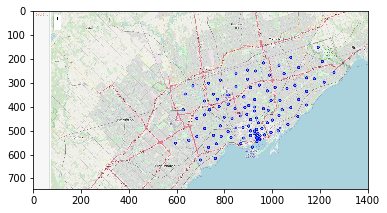

In [11]:
# The code was removed by Watson Studio for sharing.

Next code contain Parameters for foursquare connexion so hide the code

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
# define limit and radius
LIMIT = 100
radius = 500

In [14]:
# defin function to get venues (copy from notebook on NYC)
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(names=Toronto_df['Neighborhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Queen's Park
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West, Riv

In [16]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
5,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
6,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
7,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
8,Victoria Village,43.725882,-79.315572,Cash Money,43.725486,-79.312665,Financial or Legal Service
9,Harbourfront,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery


In [17]:
toronto_venues.shape

(2225, 7)

In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",13,13,13,13,13,13
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,56,56,56,56,56,56


#### Analyse Neighborhoods ####

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category ####

In [20]:

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.0,0.020000,0.00,0.000000,0.000000,0.0000,0.010000,0.000000,0.01,0.000000
1,Agincourt,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
4,"Alderwood, Long Branch",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
5,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.050000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
6,Bayview Village,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
7,"Bedford Park, Lawrence Manor East",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
8,Berczy Park,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.017857,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000
9,"Birch Cliff, Cliffside West",0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000


#### print each neighborhood along with the top 5 most common venues ####

In [21]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.06
1   Thai Restaurant  0.04
2        Steakhouse  0.04
3              Café  0.04
4  Sushi Restaurant  0.03


----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2  Latin American Restaurant   0.2
3             Clothing Store   0.2
4               Skating Rink   0.2


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                        venue  freq
0                        Park   0.5
1                  Playground   0.5
2           Accessories Store   0.0
3               Metro Station   0.0
4  Modern European Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
            venue  freq
0     Pizza Place  0.15
1   Grocery Store  0.15
2        Pharmacy  0.08
3  Discount Store  0.08
4    Liquor Store  0.08


----Alderwood, Long Branch----
 

In [22]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
#create new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,Restaurant,Cosmetics Shop,Sushi Restaurant,Bar,Burger Joint,Bakery
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Beer Store,Japanese Restaurant,Sandwich Place,Discount Store,Liquor Store,Coffee Shop
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Pub,Pool,Sandwich Place,Dance Studio,Skating Rink,Gym,Doner Restaurant


#### Clustering ####

In [24]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 
# to change use .astype()

array([3, 3, 4, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 4, 0, 3, 0, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 4, 1, 3, 0,
       0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 0, 3, 0, 3, 0, 3, 4, 0, 3, 0,
       4, 3, 3, 3, 3, 3, 4, 0, 4, 2, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3,
       3, 4, 0, 0, 0, 4, 0, 0, 0, 0, 3, 4], dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = Toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Bus Stop,Park,Food & Drink Shop,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Yoga Studio
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Coffee Shop,Intersection,Pizza Place,Financial or Legal Service,Hockey Arena,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,3.0,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,Mexican Restaurant,Farmers Market,Restaurant
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,3.0,Accessories Store,Clothing Store,Women's Store,Boutique,Sporting Goods Shop,Miscellaneous Shop,Furniture / Home Store,Event Space,Vietnamese Restaurant,Coffee Shop
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0.0,Coffee Shop,Park,Gym,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place,Restaurant,Portuguese Restaurant,Café


In [26]:
toronto_merged=toronto_merged.dropna()

In [27]:
toronto_merged['Cluster_Labels'] = toronto_merged.Cluster_Labels.astype(int)

In [28]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Dowload of the image because foliumm doesn't work with github repository

capstoneprojectnotebook-donotdelete-pr-7hqecsvgvi80bc Toronto_cluster.jpg
<class 'ibm_botocore.response.StreamingBody'>
cgsReadImage: 
	Bucket=capstoneprojectnotebook-donotdelete-pr-7hqecsvgvi80bc 
	File=Toronto_cluster.jpg 
	ArraySize=2365290 (615, 1282, 3) Type=uint8



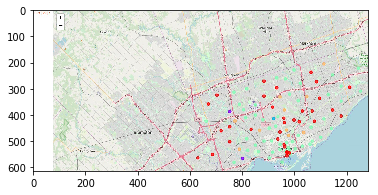

In [29]:
# The code was removed by Watson Studio for sharing.

In [30]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Portuguese Restaurant,Coffee Shop,Intersection,Pizza Place,Financial or Legal Service,Hockey Arena,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner
4,Downtown Toronto,0,Coffee Shop,Park,Gym,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place,Restaurant,Portuguese Restaurant,Café
5,Queen's Park,0,Coffee Shop,Park,Gym,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place,Restaurant,Portuguese Restaurant,Café
8,East York,0,Pizza Place,Fast Food Restaurant,Gym / Fitness Center,Intersection,Athletics & Sports,Bus Line,Gastropub,Bank,Pharmacy,Pet Store
13,North York,0,Coffee Shop,Gym,Beer Store,Asian Restaurant,Supermarket,Concert Hall,Clothing Store,Chinese Restaurant,Dim Sum Restaurant,Restaurant
17,Etobicoke,0,Café,Pizza Place,Beer Store,Cosmetics Shop,Convenience Store,Liquor Store,Coffee Shop,Pet Store,Comfort Food Restaurant,Dim Sum Restaurant
22,Scarborough,0,Coffee Shop,Pharmacy,Korean Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
23,East York,0,Sporting Goods Shop,Coffee Shop,Sushi Restaurant,Furniture / Home Store,Burger Joint,Supermarket,Dessert Shop,Fish & Chips Shop,Sports Bar,Liquor Store
24,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Café,Japanese Restaurant,Sandwich Place,Juice Bar,Burger Joint,Ice Cream Shop,Thai Restaurant,Department Store
28,North York,0,Coffee Shop,Middle Eastern Restaurant,Pet Store,Bank,Supermarket,Sushi Restaurant,Deli / Bodega,Restaurant,Pizza Place,Fried Chicken Joint


In [31]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,1,Baseball Field,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Farmers Market
101,Etobicoke,1,Baseball Field,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Farmers Market


In [32]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,2,Garden,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Deli / Bodega


In [33]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,3,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,Mexican Restaurant,Farmers Market,Restaurant
3,North York,3,Accessories Store,Clothing Store,Women's Store,Boutique,Sporting Goods Shop,Miscellaneous Shop,Furniture / Home Store,Event Space,Vietnamese Restaurant,Coffee Shop
6,Scarborough,3,Fast Food Restaurant,Print Shop,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
7,North York,3,Gym / Fitness Center,Café,Caribbean Restaurant,Baseball Field,Japanese Restaurant,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant
9,Downtown Toronto,3,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Japanese Restaurant,Theater,Pizza Place,Fast Food Restaurant,Bubble Tea Shop,Italian Restaurant
10,North York,3,Park,Japanese Restaurant,Pizza Place,Pub,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
12,Scarborough,3,History Museum,Bar,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio,Department Store
14,East York,3,Park,Curling Ice,Beer Store,Video Store,Pharmacy,Spa,Skating Rink,Asian Restaurant,Cosmetics Shop,Yoga Studio
15,Downtown Toronto,3,Coffee Shop,Café,Restaurant,Cosmetics Shop,Hotel,Breakfast Spot,Beer Bar,American Restaurant,Diner,Bakery
16,York,3,Hockey Arena,Field,Playground,Trail,Yoga Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


In [34]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,4,Bus Stop,Park,Food & Drink Shop,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Yoga Studio
21,York,4,Park,Pool,Women's Store,Gourmet Shop,Golf Course,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
35,East York,4,Convenience Store,Park,Coffee Shop,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
61,Central Toronto,4,Park,Swim School,Bus Line,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Event Space
64,York,4,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
66,North York,4,Park,Bar,Bank,Convenience Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop,Donut Shop
83,Central Toronto,4,Park,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
85,Scarborough,4,Park,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
91,Downtown Toronto,4,Park,Trail,Playground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
98,Etobicoke,4,Park,River,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
